In [1]:
from opensoundscape.annotations import BoxedAnnotations
import os
import pandas as pd
import numpy as np
import torch
import random

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [43]:
import wandb

try:
    wandb.login()
    wandb_session = wandb.init(
        entity="revo2023",  # replace with your entity/group name
        project="Agile Modeling and Opensoundscape",
        name="Only",
    )
except:  # if wandb.init fails, don't use wandb logging
    print("failed to create wandb session. wandb session will be None")
    wandb_session = None

/home/reindert/miniconda3/envs/opensoundscape/lib/python3.11/site-packages/wandb/analytics/sentry.py:259: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}  # noqa


# Create training and validation set and train a Resnet-18 CNN

In [2]:
name_experiment = 'texel_baseline_20250331'
train_set_dir = os.path.join('/home/reindert/Valentin_REVO/surfperch_toshare/eval_texel Outputs/september 2024/surfperch/labeled_outputs/', name_experiment)

pos_samples_file = os.listdir(os.path.join(train_set_dir, 'fishA')) 
neg_samples_file = os.listdir(os.path.join(train_set_dir, 'Unknown'))

pos_samples_file = [os.path.join(train_set_dir, 'fishA', file) for file in pos_samples_file]
neg_samples_file = [os.path.join(train_set_dir, 'Unknown', file) for file in neg_samples_file]

df_pos = pd.DataFrame()
df_neg = pd.DataFrame()

# Add positive sample file in the dataframe in a column file and create a column label with 1
df_pos['file'] = pos_samples_file
df_pos['start_time'] = 0.0
df_pos['end_time'] = 5.0
df_pos['A'] = 1

# Add negative sample file in the dataframe in a column file and create a column label with 0
df_neg['file'] = neg_samples_file
df_neg['start_time'] = 0.0
df_neg['end_time'] = 5.0
df_neg['A'] = 0

# concatenate the two dataframe
df_trainset = pd.concat([df_pos, df_neg], ignore_index=True)
df_trainset['A'].value_counts()

# Save the df as csv in the current repo
df_trainset.to_csv('train_set_baseline.csv', index=False)

In [3]:
# TODO - Change to 5-fold validation
# Prepare train and valid set
import sklearn.model_selection

df_trainset = pd.read_csv('train_set_baseline.csv', index_col=[0,1,2])
train_df, valid_df = sklearn.model_selection.train_test_split(df_trainset, test_size=0.2, random_state=0, stratify=df_trainset['A'])

In [47]:
train_df.iloc[5]

A    0
Name: (/home/reindert/Valentin_REVO/surfperch_toshare/eval_texel Outputs/september 2024/surfperch/labeled_outputs/texel_baseline_20250331/Unknown/7539.240908180307part7___255.0.wav, 0.0, 5.0), dtype: int64

In [50]:
from sklearn.model_selection import StratifiedKFold

# Create the 5-fold validation object
seed = 0
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
fish_sound ='A'

# Iterate over the folds
for i, (train_index, test_index) in enumerate(kf.split(train_df, train_df[fish_sound])):
    # For verification and debugging purposes
    print(f"Fold {i}:")
    print(f"Train index: {train_index}")
    print(f"Test index: {test_index}")
    print("size of each label in train set")
    print(train_df.iloc[test_index][fish_sound].value_counts())
    print("\n")



Fold 0:
Train index: [  0   1   2   3   6   7   8  10  11  12  13  14  18  19  21  22  23  24
  25  26  27  28  29  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  51  52  54  55  56  57  58  60  61  62  63  64  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  82  84  85  86  88
  89  90  91  93  94  95  96  97  98 101 102 103 104 105 108 110 111 112
 113 114 115 116 118 119]
Test index: [  4   5   9  15  16  17  20  30  31  50  53  59  65  66  81  83  87  92
  99 100 106 107 109 117]
size of each label in train set
A
0    12
1    12
Name: count, dtype: int64


Fold 1:
Train index: [  0   1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19
  20  21  22  23  24  26  27  28  30  31  33  34  37  39  40  41  42  44
  45  46  47  48  49  50  51  53  54  55  57  58  59  61  62  63  64  65
  66  68  69  70  71  73  75  77  78  79  81  82  83  86  87  88  89  90
  91  92  94  97  98  99 100 101 102 103 104 105 106 107 109 111 112 113
 114 115 116 

In [17]:
from opensoundscape import CNN
# We use Resnet as most common architeture used in Bioacoustics (ref: Stowell 2022)
# Resnet 18 because how dataset is small (avoid overfitting)

architecture = 'resnet18' 
class_list = ['A']
model = CNN(architecture=architecture,
            classes=class_list,
            sample_duration=5.0,
            overlay_df=None)

print(f"model.device is {model.device}")

model.device is cuda:0


### Subprocess / preprocess

In [ ]:
# from opensoundscape.preprocess.actions import Action
# from opensoundscape.preprocess.action_functions import pcen

# # TODO - Not working, returns blank spectrums, assuming pcen is called from librosa with require data to correct scale

# model.preprocessor.insert_action(
#     action_index="PCEN",  # give it a name
#     action=Action(pcen),  # the action object
#     after_key="bandpass",  # where to put it (can also use before_key=...)
# )

In [33]:
# TODO - Try the different data augmentation and associated perf

# Data augmentation available in the pipeline
model.preprocessor.pipeline.random_trim_audio.bypass = False

# model.preprocessor.pipeline.overlay.bypass = True
# model.preprocessor.pipeline.overlay.overlay_df = (train_df.astype(int))
# model.preprocessor.pipeline.overlay.set(overlay_class='A')

model.preprocessor.pipeline.time_mask.bypass = False
model.preprocessor.pipeline.time_mask.set(max_masks=2, max_width=0.1)

model.preprocessor.pipeline.frequency_mask.bypass = False
model.preprocessor.pipeline.frequency_mask.set(max_masks=2, max_width=0.1)

model.preprocessor.pipeline.add_noise.bypass = False

model.preprocessor.pipeline.random_affine.bypass = True

model.preprocessor.pipeline.bandpass.set(min_f=50, max_f=2000)
sample_rate = 32000
model.preprocessor.pipeline.to_spec.set(window_samples = 4 * (sample_rate // 100),
                                        # overlap_samples = None,
                                        # fft_size = None,
                                        # dB_scale = True,
                                        # scaling = 'spectrum'
                                        )

## Check spectrograms visuals
Show samples of the training set, so data augmentation are visible as well, but deactivated for validation and test set

In [35]:
from opensoundscape.data_selection import resample
augmented_train_df = resample(train_df, n_samples_per_class=200, n_samples_without_labels=200, random_state=0)
train_df.shape
augmented_train_df.value_counts()

A
0    200
1    200
Name: count, dtype: int64

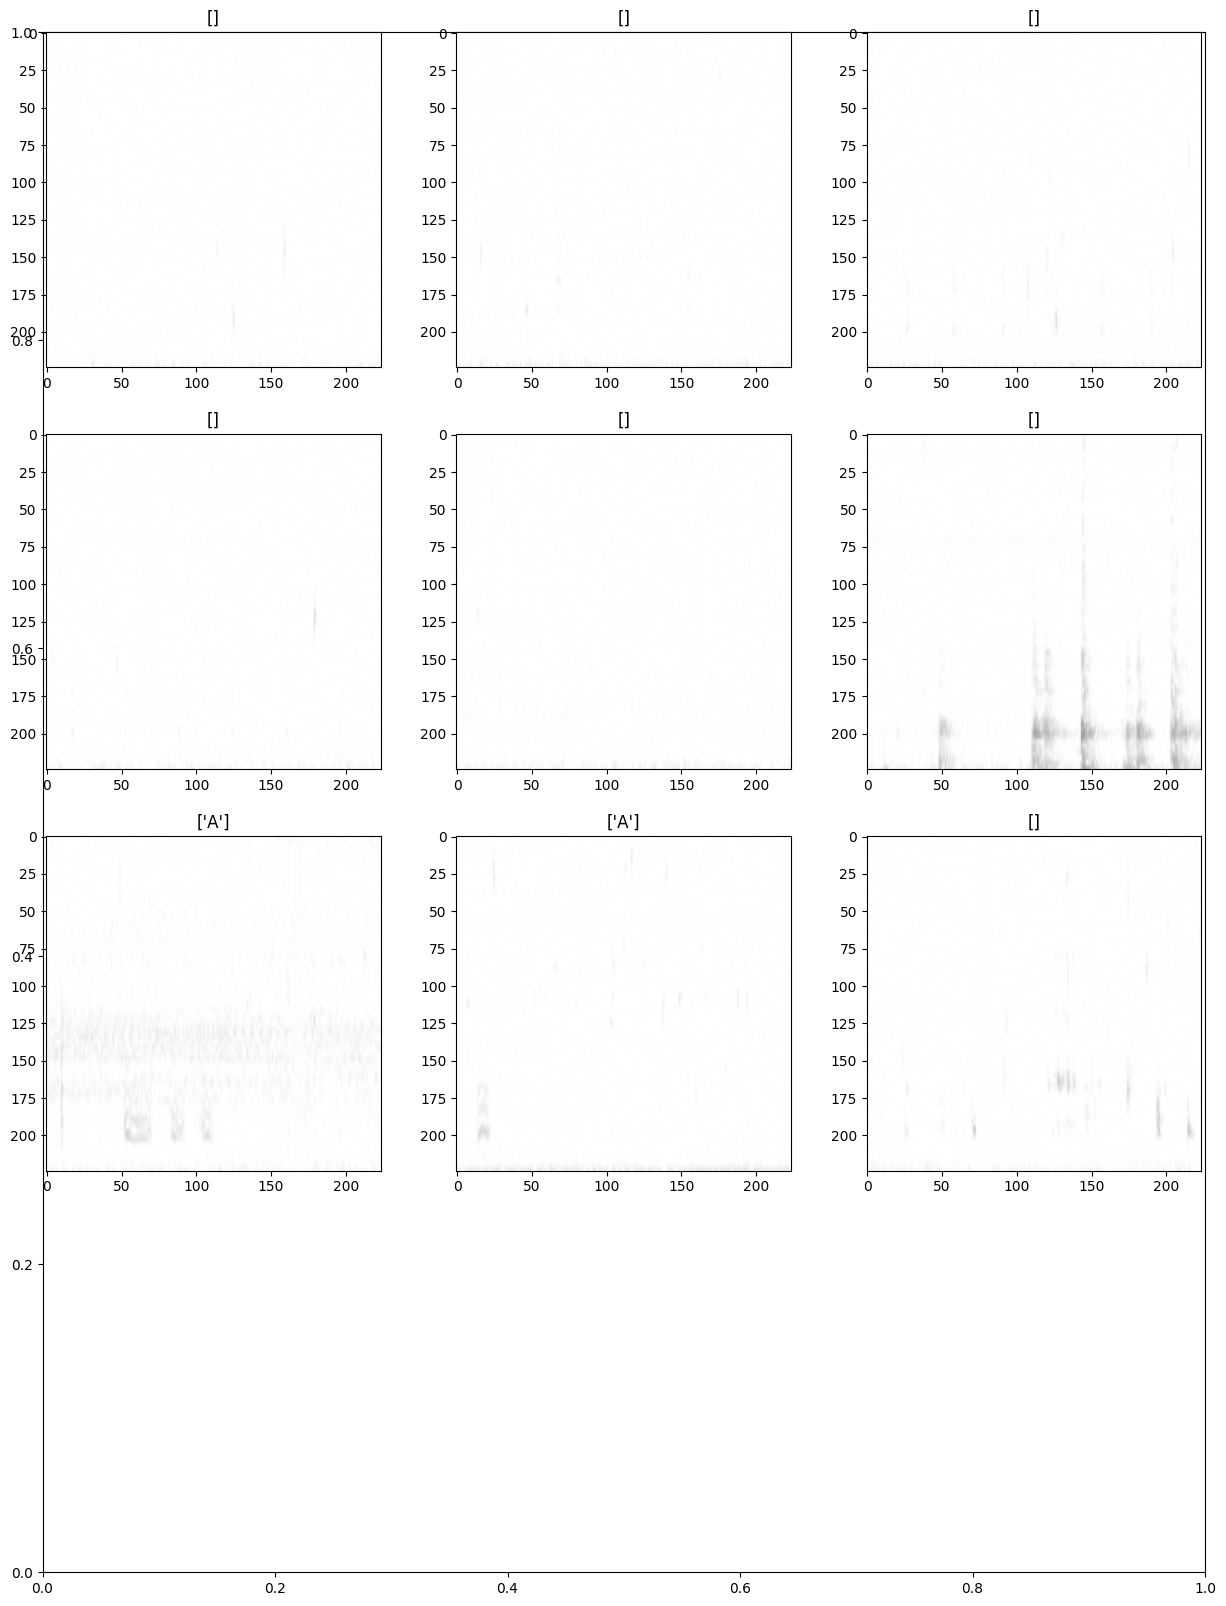

In [37]:
from opensoundscape.preprocess.utils import show_tensor_grid
from opensoundscape import AudioFileDataset

dataset = AudioFileDataset(train_df, model.preprocessor)

dataset.preprocessor.pipeline.overlay.set(overlay_class=None)

# Only select negative class from train set
# neg_train_df = train_df[train_df['A'] == 0]
# fish_sound = 'A'
# neg_train_df = train_df[train_df[fish_sound] == 0]
# neg_train_df[fish_sound] = 1
# dataset.preprocessor.pipeline.overlay.overlay_df = (neg_train_df.astype(int))
# dataset.preprocessor.pipeline.overlay.set(overlay_class=fish_sound)

tensors = [dataset[i].data for i in range(9)]
sample_labels = [list(dataset[i].labels[dataset[i].labels > 0].index) for i in range(9)]

_ = show_tensor_grid(tensors, 3, labels=sample_labels)

## Training

In [47]:
from pathlib import Path
checkpoint_folder = Path("model_training_checkpoints")
checkpoint_folder.mkdir(exist_ok=True)

model.train(
    augmented_train_df,
    valid_df,
    epochs=5,
    batch_size=8,
    num_workers=16,
    wandb_session=wandb_session,
    save_interval=5,  # save checkpoint every 10 epochs
    save_path=checkpoint_folder,  # location to save checkpoints
    progress_bar=False
)


Training Epoch 10


/home/reindert/miniconda3/envs/opensoundscape/lib/python3.11/site-packages/opensoundscape/ml/cnn.py:213: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.use_amp)


Epoch: 10 [batch 0/50, 0.00%] 
	Epoch Running Average Loss: 0.058
	Most Recent Batch Loss: 0.058
Epoch: 10 [batch 10/50, 20.00%] 
	Epoch Running Average Loss: 0.159
	Most Recent Batch Loss: 0.202
Epoch: 10 [batch 20/50, 40.00%] 
	Epoch Running Average Loss: 0.135
	Most Recent Batch Loss: 0.383
Epoch: 10 [batch 30/50, 60.00%] 
	Epoch Running Average Loss: 0.141
	Most Recent Batch Loss: 0.027
Epoch: 10 [batch 40/50, 80.00%] 
	Epoch Running Average Loss: 0.161
	Most Recent Batch Loss: 0.059

Validation.


  0%|          | 0/4 [00:00<?, ?it/s]


Training Epoch 11
Epoch: 11 [batch 0/50, 0.00%] 
	Epoch Running Average Loss: 0.020
	Most Recent Batch Loss: 0.020
Epoch: 11 [batch 10/50, 20.00%] 
	Epoch Running Average Loss: 0.273
	Most Recent Batch Loss: 0.102
Epoch: 11 [batch 20/50, 40.00%] 
	Epoch Running Average Loss: 0.207
	Most Recent Batch Loss: 0.075
Epoch: 11 [batch 30/50, 60.00%] 
	Epoch Running Average Loss: 0.202
	Most Recent Batch Loss: 0.101
Epoch: 11 [batch 40/50, 80.00%] 
	Epoch Running Average Loss: 0.183
	Most Recent Batch Loss: 0.191

Validation.


  0%|          | 0/4 [00:00<?, ?it/s]


Training Epoch 12
Epoch: 12 [batch 0/50, 0.00%] 
	Epoch Running Average Loss: 0.120
	Most Recent Batch Loss: 0.120
Epoch: 12 [batch 10/50, 20.00%] 
	Epoch Running Average Loss: 0.157
	Most Recent Batch Loss: 0.052
Epoch: 12 [batch 20/50, 40.00%] 
	Epoch Running Average Loss: 0.128
	Most Recent Batch Loss: 0.096
Epoch: 12 [batch 30/50, 60.00%] 
	Epoch Running Average Loss: 0.129
	Most Recent Batch Loss: 0.060
Epoch: 12 [batch 40/50, 80.00%] 
	Epoch Running Average Loss: 0.121
	Most Recent Batch Loss: 0.193

Validation.


  0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _releaseLock at 0x7e1ea4f8db20>
Traceback (most recent call last):
  File "/home/reindert/miniconda3/envs/opensoundscape/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 182638, 182639, 182640, 182641, 182642, 182643, 182644, 182645, 182646, 182647) exited unexpectedly

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7e1e75172c10>> (for post_run_cell), with arguments args (<ExecutionResult object at 7e1e74cf6c90, execution_count=47 error_before_exec=None error_in_exec=DataLoader worker (pid(s) 182638, 182639, 182640, 182641, 182642, 182643, 182644, 182645, 182646, 182647) exited unexpectedly info=<ExecutionInfo object at 7e1e74cc7050, raw_cell="from pathlib import Path
checkpoint_folder = Path(.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/reindert/Valentin_REVO/Opensoundscape/train_cnn.ipynb#X20sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

## Test set

In [ ]:
test_files_path = '/home/reindert/Valentin_REVO/surfperch_toshare/eval_texel Data/september 2024/test_set/'
test_files_list = os.listdir(test_files_path)

# Create a list of all wav files with files ending by .wav
wav_files = sorted([file for file in test_files_list if file.endswith('.wav')])
annot_files = sorted([file for file in test_files_list if file.endswith('.txt')])

wav_files = [os.path.join(test_files_path, file) for file in wav_files]
annot_files = [os.path.join(test_files_path, file) for file in annot_files]

print("Checking files order\n", wav_files[:3])
print(annot_files[:3])

selection_files = annot_files
audio_files = wav_files

annotations = BoxedAnnotations.from_raven_files(raven_files=selection_files, audio_files=audio_files, annotation_column='Type')

clip_duration = 5.0
clip_overlap = 0
min_label_overlap = 0.2
species_of_interest = ['A']

clip_labels = annotations.clip_labels(
    clip_duration=clip_duration,
    clip_overlap=clip_overlap,
    min_label_overlap=min_label_overlap,
    class_subset=species_of_interest)

clip_labels.value_counts()

In [ ]:
pred_testset = model.predict(clip_labels, batch_size=64, num_workers=16, activation_layer='sigmoid', wandb_session=wandb_session)
predict_validset = model.predict(valid_df, batch_size=8, num_workers=16, activation_layer='sigmoid', wandb_session=wandb_session)

## Metrics calculation

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, auc

# Compute precision from logits and labels
valid_labels = valid_df['A'].values
valid_pred = predict_validset['A'].values.round() #Threshold = 0.5

precision_valid = precision_score(valid_labels, valid_pred, pos_label=1, average='binary')
recall_valid = recall_score(valid_labels, valid_pred, pos_label=1, average='binary')
f1_valid = f1_score(valid_labels, valid_pred, pos_label=1, average='binary')
auc_roc_valid = roc_auc_score(valid_labels, predict_validset['A'].values)
precision, recall, _thresholds = precision_recall_curve(valid_labels, predict_validset['A'].values)
auc_precision_recall_valid = auc(recall, precision)

test_labels = clip_labels['A'].values
test_pred = pred_testset['A'].values.round()

precision_test = precision_score(test_labels, test_pred, pos_label=1, average='binary')
recall_test = recall_score(test_labels, test_pred, pos_label=1, average='binary')
f1_test = f1_score(test_labels, test_pred, pos_label=1, average='binary')
auc_roc_test = roc_auc_score(test_labels, pred_testset['A'].values)
precision, recall, _thresholds = precision_recall_curve(test_labels, pred_testset['A'].values)
auc_precision_recall_test = auc(recall, precision)

# print all metrics
print("Validation Set")
print("Precision valid: ", precision_valid)
print("Recall valid: ", recall_valid)
print("F1 valid: ", f1_valid)
print("AUC ROC valid: ", auc_roc_valid)
print("AUC precision recall: ", auc_precision_recall_valid)

print("\n\nTest Set")
print("Precision test: ", precision_test)
print("Recall test: ", recall_test)
print("F1 test: ", f1_test)
print("AUC ROC test: ", auc_roc_test)
print("AUC precision recall: ", auc_precision_recall_test)

In [48]:
# Finish the session before next run
wandb.finish()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7e1e75172c10>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7e1e751f4610, raw_cell="# Finish the session before next run
wandb.finish(.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/reindert/Valentin_REVO/Opensoundscape/train_cnn.ipynb#X26sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7e1e75172c10>> (for post_run_cell), with arguments args (<ExecutionResult object at 7e1e751f0890, execution_count=48 error_before_exec=None error_in_exec=[Errno 32] Broken pipe info=<ExecutionInfo object at 7e1e751f4610, raw_cell="# Finish the session before next run
wandb.finish(.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/reindert/Valentin_REVO/Opensoundscape/train_cnn.ipynb#X26sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe